In [1]:
TEST_IMG_FOLDER = 'test_images/'
STRAIGHTLINE_IMG = 'test_images/straight_lines2.jpg'
CAL_IMG_FOLDER = 'camera_cal/'
OUT_IMG_FOLDER = 'output_images/'

output_name = 'output_video/project_video_annotated.mp4'
input_name = 'project_video.mp4'

# TEST_IMG_FOLDER = 'challenge_test_images/'
# STRAIGHTLINE_IMG = 'test_images/straight_lines2.jpg'
# CAL_IMG_FOLDER = 'camera_cal/'
# OUT_IMG_FOLDER = 'challenge_output_images/'

# input_name = 'challenge_video.mp4'
# output_name = 'output_video/challenge_video_annotated.mp4'

In [2]:
from tqdm import tqdm
from glob import glob
import cv2

import numpy as np

# list of chessboard images for calibration, sorted by index for convenience
img_list = sorted(glob(CAL_IMG_FOLDER + '*.jpg'), key = lambda x: int(x.split('.')[0].split('n')[1]))

# list of chessboard corners and dest. coordinate
imgpoints, objpoints = [], []

# number of inner corners in each dimension
nx, ny = 9, 6

# default undistorted chessboard coordinates
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# display the chessboard images together with the identified corners
for i in tqdm(range(len(img_list))):
    img = cv2.imread(img_list[i])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)            
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if found the corners, add them to the list 
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
    
# Calcualte the undistortion matrix 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None,None)

# define a function that will correct for distortion an arbitrary image
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


100%|██████████| 20/20 [00:06<00:00,  2.80it/s]


In [3]:
# a helper function to plot a grid of images from an iterable (list or generator)
def plt_grid_image(img_iterable, grid_shape, img_shape, titles, width=12):
    n_rows, n_cols = grid_shape
    img_height, img_width = img_shape
    
    height = int(1.0*(img_height*n_rows)*width/(n_cols*img_width))
    
    fig = plt.figure(figsize=(width, height), facecolor='white')
    gs = gridspec.GridSpec(n_rows, n_cols, top=0.96, bottom=0.02, right=0.98, left=0.02, hspace=0.001, wspace=0.001)
    
    i = 0
    for imgs in img_iterable:
        j = 0
        for img in imgs:
            ax = plt.subplot(gs[i*n_cols + j])
            ax.imshow(img)
            ax.axis('off')
            if i==0:
                ax.set_title(titles[j], fontsize=18)

            j += 1
            if j == n_cols:
                break
        i+=1
        if i == n_rows:
            break
            
# helper functions to convert colors
def gray2bgr(gray):
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

def RGB(img):
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)


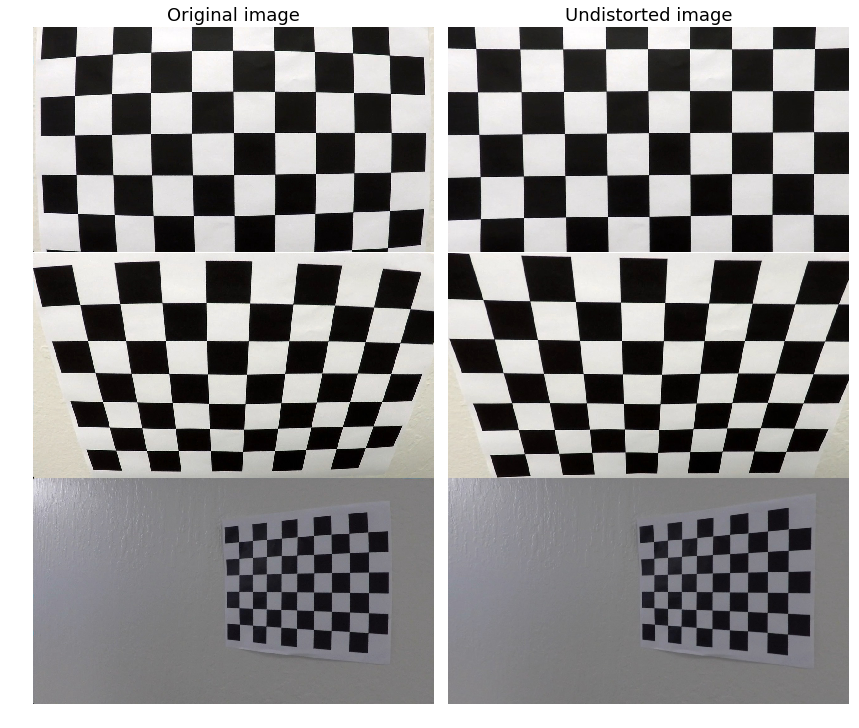

In [4]:
# display undistorted images
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# find the image size from an arbitrary imagein the folder
img_list = sorted(glob(CAL_IMG_FOLDER + '*.jpg'), key = lambda x: int(x.split('.')[0].split('n')[1]))
img = cv2.imread(img_list[0])
img_height, img_width = img.shape[:2]
example_img_list = [img_list[i] for i in [0,1,11]]

def undistorted_img_generator(img_list):
    for img_name in img_list:
        img = cv2.imread(img_name)
        yield (RGB(img), RGB(undistort(img)))
  
plt_grid_image(undistorted_img_generator(example_img_list), 
               (len(example_img_list), 2), 
               img.shape[:2], 
               ['Original image', 'Undistorted image'])

plt.savefig(OUT_IMG_FOLDER + 'undistorted_chessboards.jpg')

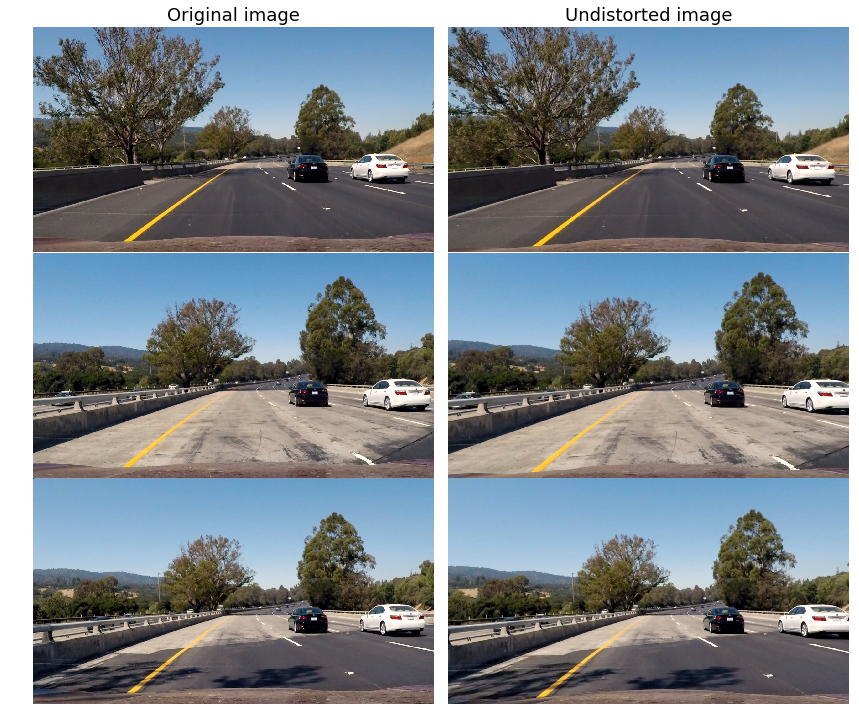

In [5]:
test_img_list = glob(TEST_IMG_FOLDER + 'test*.jpg')
example_test_img_list = [test_img_list[i] for i in [0,1,3]]

plt_grid_image(undistorted_img_generator(example_test_img_list), 
               (len(example_test_img_list), 2), 
               img.shape[:2], 
               ['Original image', 'Undistorted image'])

plt.savefig(OUT_IMG_FOLDER + 'undistorted_imgs.jpg')

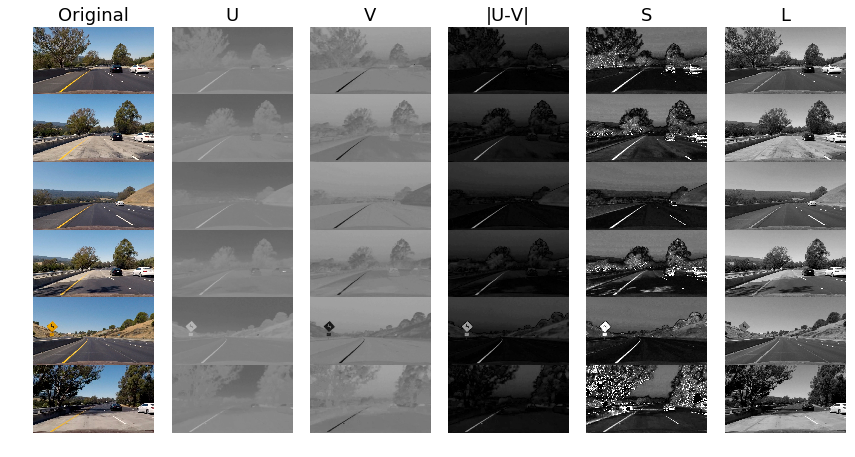

In [6]:
# Investigate the detection capability of various channels
def channel_img_generator(img_list):
    for img_name in img_list:
        img = cv2.imread(img_name)
        img = undistort(img)
        y,u,v = cv2.split(cv2.cvtColor(img,cv2.COLOR_BGR2YUV))
        h,l,s = cv2.split(cv2.cvtColor(img,cv2.COLOR_BGR2HLS))
        uv = np.abs(u.astype(np.int32) - v.astype(np.int32))
        uv = np.minimum(uv, 255).astype(np.uint8)
        
        yield (RGB(img), gray2bgr(u), gray2bgr(v), gray2bgr(uv), gray2bgr(s), gray2bgr(l))

img_list = glob(TEST_IMG_FOLDER + 'test*.jpg')
titles = ['Original', 'U', 'V', '|U-V|', 'S', 'L']
n_rows = len(img_list)
n_cols = len(titles)

plt_grid_image(channel_img_generator(img_list), (n_rows, n_cols), (img_height, img_width), titles)
plt.savefig(OUT_IMG_FOLDER + 'channels.jpg')
    

In [7]:
def scaled(x, maximum=255.0, outtype=np.uint8):
    return (x*maximum/np.max(x)).astype(outtype)

def mask_thresh(x, thresh):
    return (x >= thresh[0]) & (x <= thresh[1])

def gaussian_blur(img, kernel=5):
    blur = np.zeros_like(img)
    top = img.shape[0]*2//3
    blur[top:] = cv2.GaussianBlur(img[top:],(kernel,kernel),0)
    blur[:top] = img[:top, :]
    return blur

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def pipeline(img, sx_thresh=20, sl_thresh=225, suv_thresh = 100):
    # Apply gaussian blur to reduce noise
    img = gaussian_blur(img)

    # Convert to YUV and use U and V to detect yellow
    y,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YUV))
    uv = scaled(np.abs(u.astype(np.int32) - v.astype(np.int32)))
    
    # Convert to HSL and use L to detect white
    h,l,s = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HLS))
    l = clahe.apply(l)
    
    # Gradient
    gray = clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)) # Take the derivative in x
    
    mask_sx = scaled(sobelx) > sx_thresh
    mask_white = (l>sl_thresh)
    mask_yellow = (uv>suv_thresh)
    
    ooo = np.zeros_like(mask_sx).astype(np.bool)    
    
    # Stack each channel
    color_binary = np.dstack((mask_yellow, mask_white, mask_sx))
    return color_binary


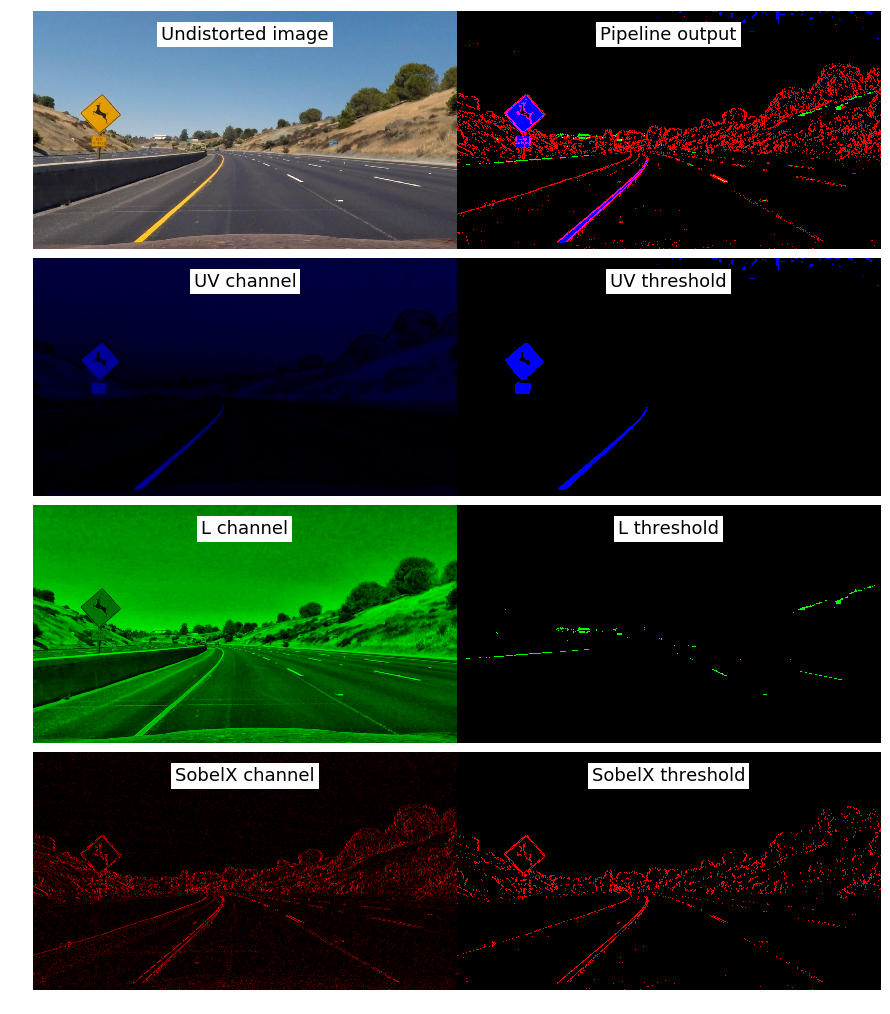

In [8]:
# Display an example of the pipeline
example_img = undistort(cv2.imread(TEST_IMG_FOLDER + 'test2.jpg'))
color_binary = pipeline(example_img)

y,u,v = cv2.split(cv2.cvtColor(example_img, cv2.COLOR_BGR2YUV))
uv = np.minimum(abs(u.astype(np.int32) - v.astype(np.int32)),255).astype(np.uint8)

# Convert to HSL and use L to detect white
l = clahe.apply(cv2.cvtColor(example_img, cv2.COLOR_BGR2HLS)[:,:,1])

# Gradient
gray = clahe.apply(cv2.cvtColor(example_img, cv2.COLOR_BGR2GRAY))
sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3))

mask_sx = scaled(sobelx) > 40
mask_white = l > 225
mask_yellow = scaled(uv) > 100

n_cols, n_rows = 2, 4
width = 12
height = int((n_rows*img_height)*1.0*(width+1)/(n_cols*img_width))

fig = plt.figure(figsize=(width,height), facecolor='white')
gs = gridspec.GridSpec(n_rows, n_cols, top=0.99, bottom=0.01, right=0.99, left=0.01, hspace=0.001, wspace=0.001)

def channel2rgb(gray, channel):
    img = np.zeros((*gray.shape,3), dtype=np.uint8)
    img[:,:,channel] = gray
    return img

axes = [plt.subplot(gs[i]) for i in range(n_rows*n_cols)]
axes[0].imshow(RGB(example_img))
axes[1].imshow(RGB(color_binary)*255)
axes[2].imshow(channel2rgb(uv,2))
axes[3].imshow(channel2rgb(mask_yellow*255,2))
axes[4].imshow(channel2rgb(l,1))
axes[5].imshow(channel2rgb(mask_white*255,1))
axes[6].imshow(channel2rgb(sobelx,0))
axes[7].imshow(channel2rgb(mask_sx*255,0))

titles = ['Undistorted image', 'Pipeline output', 'UV channel', 'UV threshold', 
          'L channel', 'L threshold', 'SobelX channel', 'SobelX threshold']

for i in range(len(axes)):
    axes[i].axis('off')
    axes[i].text(0.5, 0.9, titles[i], 
                 horizontalalignment='center', 
                 verticalalignment='center',
                 transform = axes[i].transAxes,
                 bbox=dict(facecolor='white', edgecolor='none'), fontsize=18)
plt.savefig(OUT_IMG_FOLDER + 'pipeline.jpg')

In [9]:
# # project video
# source_points = [(267, 670), (1038, 670), (768,500), (520,500)]
# warped_points = [(267, 700), (1028, 700), (1028,550), (267,550)]

# source_points = [(580, 460), (203, 720), (1127,720), (708,460)]
source_points = [(608, 440), (203, 720), (1127,720), (676,440)]
warped_points = [(320, 0), (320, 720), (960,720), (960,0)]

# # challenge video
# source_points = [(253, 700), (997, 700), (740,500), (565,500)]
# warped_points = [(150, 710), (1070, 710), (1070,250), (150,250)]

# # harder challenge video
# source_points3 = [(200, 690), (990, 690), (813,550), (422,550)]
# warped_points3 = [(200, 740), (1000, 740), (1000,550), (200,550)]

source_points = np.float32(source_points)
warped_points = np.float32(warped_points)
M = cv2.getPerspectiveTransform(source_points, warped_points)
Minv = cv2.getPerspectiveTransform(warped_points, source_points)

def birdeye(img):
    return cv2.warpPerspective(img, M, img.shape[:2][::-1], flags=cv2.INTER_CUBIC)

def careye(img):
    return cv2.warpPerspective(img, Minv, img.shape[:2][::-1], flags=cv2.INTER_CUBIC)

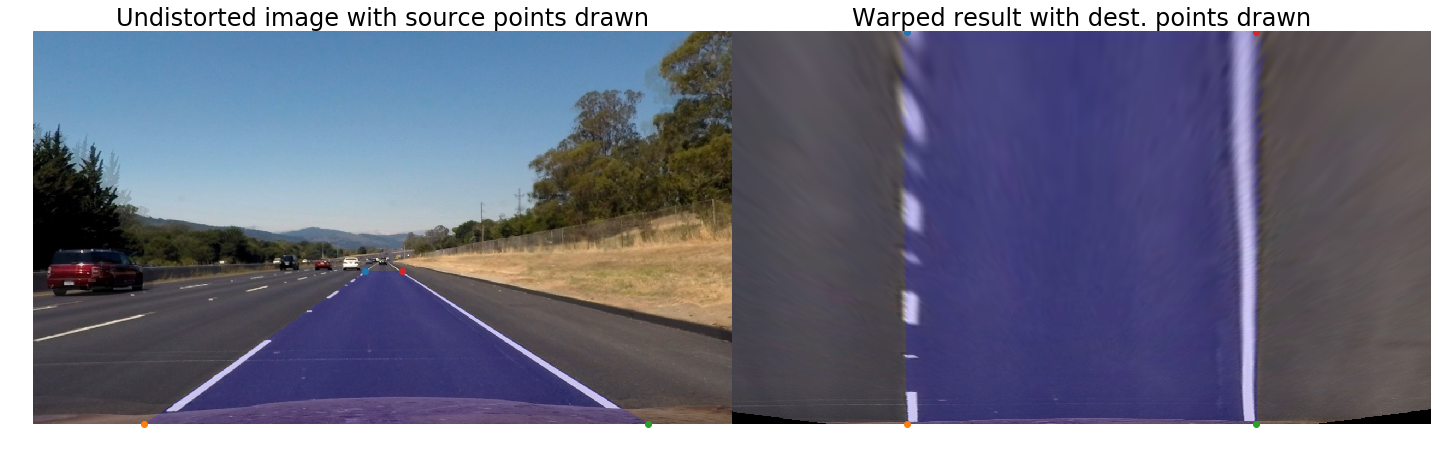

In [10]:
img = cv2.imread(STRAIGHTLINE_IMG)
undistorted_img = undistort(img)
shaded_img = img.copy()

cv2.fillConvexPoly(shaded_img, np.array(source_points).astype(np.int32), [255,0,0])
shaded_img = cv2.addWeighted(shaded_img, 0.2, undistorted_img, 0.8, 0)

fig = plt.figure(figsize=(20,8), facecolor='white')
gs = gridspec.GridSpec(1, 2, top=0.98, bottom=0.01, right=0.98, left=0.01, hspace=0.001, wspace=0.001)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.imshow(RGB(shaded_img))
ax2.imshow(RGB(birdeye(shaded_img)))

for p in source_points:
    ax1.plot(*p, 'o')
    
for p in warped_points:
    ax2.plot(*p, 'o')

for ax in [ax1, ax2]:
    ax.axis('off')
    
ax1.set_title('Undistorted image with source points drawn', fontsize=24)
ax2.set_title('Warped result with dest. points drawn', fontsize=24)
plt.savefig(OUT_IMG_FOLDER + 'warped_img.jpg')

In [11]:
def process(img):
    img = np.copy(img)
    img = undistort(img)
    img = pipeline(img).astype(np.uint8)
    img = birdeye(img)
    return img

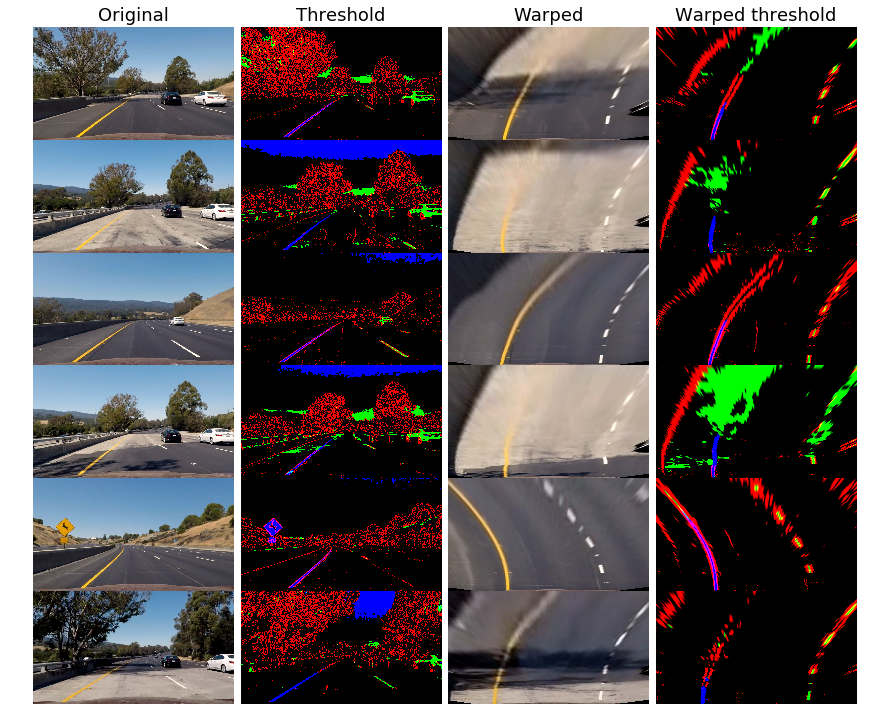

In [12]:
img_list = glob(TEST_IMG_FOLDER + 'test*.jpg')
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def local_hist_equalize(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    yuv[:,:,0] = clahe.apply(yuv[:,:,0])
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

def pipline2_img_generator(img_list):
    for img_name in img_list:
        img = undistort(cv2.imread(img_name))
        birdeye_img = birdeye(img)
        thresholded_img = (pipeline(img, sx_thresh=20)*255).astype(np.uint8)
        birdeye_thresholded_img = birdeye(thresholded_img)
        yield (RGB(img), RGB(thresholded_img), RGB(birdeye_img), RGB(birdeye_thresholded_img))


n_cols = 4
n_rows = len(img_list)
titles = ['Original', 'Threshold', 'Warped', 'Warped threshold']

plt_grid_image(pipline2_img_generator(img_list), (n_rows, n_cols), (img_height, img_width), titles)
plt.savefig(OUT_IMG_FOLDER + 'pipline_and_warp.jpg')

In [13]:
# Choose the number of sliding windows
nwindows = 9

# Set the width of the windows +/- margin
margin = 60

# Set minimum number of pixels found to recenter window
minpix = 50    

deg = 2


In [14]:
from sklearn import linear_model, datasets

def find_window_centroids(binary_warped, window_width=100, window_height=80):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    img_height, img_width = binary_warped.shape[:2]
    top, mid = img_height*2//3, img_width//2
    
    l_sum = np.sum(binary_warped[top:,:mid], axis=0)
    r_sum = np.sum(binary_warped[top:,mid:], axis=0)

    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+mid

    # Add what we found for the first layer
    window_centroids.append((int(l_center),int(r_center)))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,img_height//window_height):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(binary_warped[img_height-(level+1)*window_height:img_height-level*window_height], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,img_width))
        if np.max(conv_signal[l_min_index:l_max_index]) > 30:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,img_width))
        if np.max(conv_signal[r_min_index:r_max_index]) > 30:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((int(l_center),int(r_center)))
        
    return window_centroids

from scipy.signal import convolve2d

def find_lane_pixels_with_window_centroids(binary_warped, window_centroids, window_width=100, window_height=80):        
    img_height, img_width = binary_warped.shape[:2]

    def window_bound(centroid, level):
        bottom = min(img_height-level*window_height,img_height)
        top    = max(img_height-(level+1)*window_height,0)
        left   = max(centroid-margin,0)
        right  = min(centroid+margin,img_width)
        return top, bottom, left, right
        
    left_window_mask = np.zeros_like(binary_warped, dtype=bool)
    right_window_mask = np.zeros_like(binary_warped, dtype=bool)
    
    out_img = (np.dstack((binary_warped>0, binary_warped>0, binary_warped>0))*255).astype(np.uint8)

    for level in range(len(window_centroids)):
        left_centroid, right_centroid = window_centroids[level]
        
        t, b, l, r = window_bound(left_centroid, level)
        left_window_mask[np.arange(t,b,dtype=int), np.arange(l,r,dtype=int).reshape(-1,1)] = True
        cv2.rectangle(out_img,(l,b),(r,t),(0,255,0), 2) 
        
        t, b, l, r = window_bound(right_centroid, level)
        right_window_mask[np.arange(t,b,dtype=int), np.arange(l,r,dtype=int).reshape(-1,1)] = True
        cv2.rectangle(out_img,(l,b),(r,t),(0,255,0), 2) 
                        
    lefty, leftx = ((binary_warped>0) & left_window_mask).nonzero()
    righty, rightx = ((binary_warped>0) & right_window_mask).nonzero()
    
    leftw = binary_warped[lefty, leftx]
    rightw = binary_warped[righty, rightx]
   
    return lefty, leftx, righty, rightx, leftw, rightw, out_img



In [15]:
def fit_lane(lefty, leftx, righty, rightx, leftw, rightw, img_height, img_width):

    def make_feature(y,right):
        yy = y - img_height
        polynomial = yy**np.arange(1,3).reshape(-1,1)
        dv_right = right*np.ones_like(yy)
        interaction = dv_right*(yy**2)
        return np.vstack([polynomial, dv_right, interaction]).transpose()
    
    features_left = make_feature(lefty, False)
    features_right = make_feature(righty, True)
    
    features = np.vstack([features_left, features_right])
    output = np.hstack([leftx, rightx])
    weight = np.hstack([leftw*lefty, rightw*righty])
        
    if len(features) < 20:
        return None, None, (None, None, None)
    
#     regr = linear_model.RANSACRegressor(linear_model.LinearRegression())
    regr=linear_model.LinearRegression()
    regr.fit(features, output, weight)
        
    fity = np.arange(img_height)
    
    fit_features_left = make_feature(fity, False)
    fit_features_right = make_feature(fity, True)

    fit_leftx = regr.predict(fit_features_left)
    fit_rightx = regr.predict(fit_features_right)
    
    return regr, make_feature, (fity, fit_leftx, fit_rightx)

In [16]:
def find_lanes_pipeline(binary_warped,window_width=100, window_height=80):
    window_centroids = find_window_centroids(binary_warped,window_width,window_height)
    lefty,leftx,righty,rightx,leftw,rightw,out_img = find_lane_pixels_with_window_centroids(binary_warped, window_centroids,window_width,window_height)
    regr,make_feature,(fity,fit_leftx,fit_rightx) = fit_lane(lefty, leftx, righty, rightx, leftw,rightw, *img.shape[:2])
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img,fity,fit_leftx,fit_rightx,regr

In [17]:
def find_lane_pixels_with_previous_fit(binary_warped, fit_leftx, fit_rightx):
    nonzeroy, nonzerox = np.where(binary_warped>0)

    left_lane_inds = np.abs(nonzerox - fit_leftx[nonzeroy]) <= margin
    right_lane_inds = np.abs(nonzerox - fit_rightx[nonzeroy]) <= margin
    
    fity = np.arange(binary_warped.shape[0])

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped>0, binary_warped>0, binary_warped>0))*255).astype(np.uint8)
    
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    window_img = np.zeros_like(out_img)
    
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    cv2.polylines(result, [np.int_(list(zip(fit_leftx, fity)))], False, (0,255,255), thickness=2)
    cv2.polylines(result, [np.int_(list(zip(fit_rightx, fity)))], False, (0,255,255), thickness=2)

    leftw = binary_warped[lefty, leftx]
    rightw = binary_warped[righty, rightx]
   
    return lefty, leftx, righty, rightx, leftw, rightw, result

In [18]:
def find_lanes_pipeline2(binary_warped,fit_leftx,fit_rightx,window_width=100, window_height=80):
    lefty,leftx,righty,rightx,leftw, rightw, out_img = find_lane_pixels_with_previous_fit(binary_warped,fit_leftx,fit_rightx)
    regr,make_feature,(fity,fit_leftx,fit_rightx) = fit_lane(lefty, leftx, righty, rightx, leftw, rightw, *img.shape[:2])
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img,fity,fit_leftx,fit_rightx,regr

In [19]:
# Stitch & show restults from different stages of the pipeline
def stitch(img, processed_img_3D, out_img, fit_leftx, fit_rightx, info={}):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(processed_img_3D, dtype=np.uint8)
    img = undistort(img)
    birdeye_img = birdeye(img)
    
    fity = np.arange(img.shape[0])

    if fit_leftx is not None and fit_rightx is not None:
        # Draw the boundaries of the fitted lanes
        cv2.polylines(out_img, [np.int_(list(zip(fit_leftx, fity)))], False, (255,255,255), thickness=2)
        cv2.polylines(out_img, [np.int_(list(zip(fit_rightx, fity)))], False, (255,255,255), thickness=2)
    
        # lane center
        fit_center = (fit_leftx + fit_rightx)/2
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
        pts_center = np.array([np.flipud(np.transpose(np.vstack([fit_center, fity])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
        
        cv2.polylines(color_warp, [np.int_(pts_center)], False, (0,0,255), 20)

    lane_pixels = channel2rgb(np.any(processed_img_3D > 0, axis=2).astype(np.uint8)*255,0)
    color_warp2 = cv2.addWeighted(color_warp, 0.5, lane_pixels, 0.5, 0)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp2, Minv, (img.shape[1], img.shape[0])) 
    result = img.copy()
    
    # draw an arrow to indicate the center of the car
    cv2.arrowedLine(result, (img.shape[1]//2,img.shape[0]), (img.shape[1]//2,img.shape[0]*2//3), [0,200,200], 7,tipLength=0.1)
    result = cv2.addWeighted(result, 0.9, newwarp, 0.6, 0)
    highlighted_birdeye_img = cv2.addWeighted(birdeye_img, 1, color_warp, 0.3, 0)
    
    # Annotate of information about the curvature of the lanes onto the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    red_color = (0,0,255)
    yellow_color = (0,255,255)
    white_color = (255,255,255)
    green_color = (174,0,1)
    
    # Display radius of curvature if available
    if 'radius_of_curvature' in info:
        curvature = info['radius_of_curvature']
        turning_dir = ['Going straight' if abs(c) > 2000 else 'Turning left' if c < 0 else 'Turning right' for c in curvature]
        
        cv2.putText(result, 'Curvature = 1/{:.0f}m'.format(abs(curvature[-1])), (20, 50), font, 1, white_color,3,cv2.LINE_AA)
        cv2.putText(result, turning_dir[-1], (20, 150), font, 1, white_color,3,cv2.LINE_AA)

            
    # Display deviation to center if available
    if 'deviation' in info:
        cv2.putText(result, 'Offset = {:.3f}m'.format(info['deviation']),(20,100), font, 1,white_color,3,cv2.LINE_AA)
    
    # Display if the lanes were detected in the current frame 
    if 'detected' in info:
        detected_string, detected_color = ('Lane detected', white_color) if info['detected'] else ('Lane not detected', red_color)
        cv2.putText(result, detected_string,(20,200), font, 1,detected_color,3,cv2.LINE_AA)

    processed_img_3D = ((processed_img_3D>0)*255).astype(np.uint8)
    h,l,s = cv2.split(cv2.cvtColor(birdeye_img, cv2.COLOR_BGR2HLS))
    y,u,v = cv2.split(cv2.cvtColor(birdeye_img, cv2.COLOR_BGR2YUV))
    
    uv = np.minimum(3*np.abs(u.astype(np.int32) - v.astype(np.int32)),255).astype(np.uint8)
    uv = gray2bgr(uv)
    cv2.putText(uv, '|U-V| channel', (40,90),font, 2, yellow_color, 5)
    
    l = gray2bgr(l)
    cv2.putText(l, 'L channel', (40,90),font, 2, yellow_color, 5)
    
    cv2.putText(highlighted_birdeye_img, 'Birdeye view', (40,90),font, 2, yellow_color, 5)
    cv2.putText(processed_img_3D, 'Threshold', (40,90),font, 2, yellow_color, 5)
    cv2.putText(out_img, 'Fitted lanes', (40,90),font, 2, yellow_color, 5)

    # Stitch all the images together
    right = np.vstack([cv2.resize(uv,(426,240)), cv2.resize(l,(426,240))])
    top = np.hstack([cv2.resize(result, (854,480)), right])
    bottom = np.hstack([cv2.resize(out_img, (427,240)), 
                        cv2.resize(processed_img_3D, (427,240)), 
                        cv2.resize(highlighted_birdeye_img, (426,240))])
    stitched = np.vstack([top,  bottom])
    
    return stitched


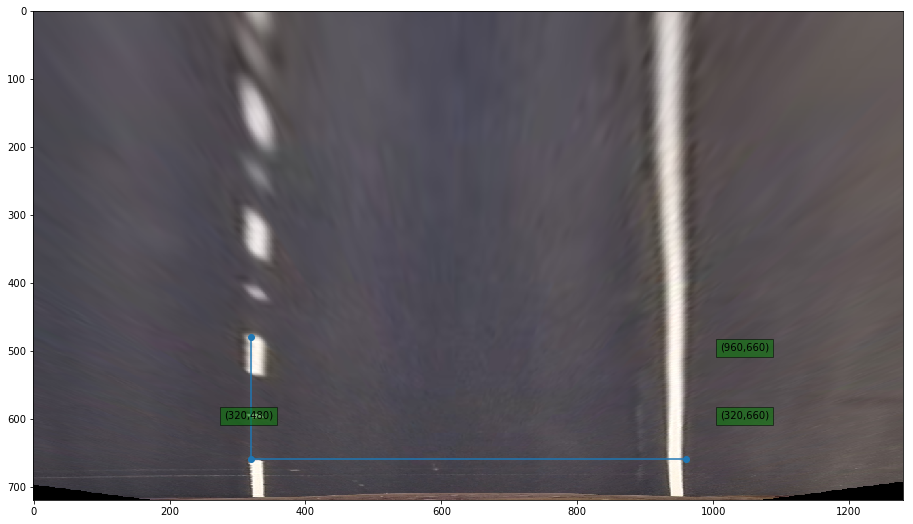

In [20]:
# Measuring meter per pixel
# img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread(STRAIGHTLINE_IMG)
img = undistort(img)
img = birdeye(img)
plt.figure(figsize=(16,9))
plt.imshow(RGB(img))

# project video
# anchor_points = [(280, 570), (1010,570), (1010,520)]
# anchor_points_label = [(280, 600), (1010,600), (1010,500)]
# warped_points = [(320, 0), (320, 720), (960,720), (960,0)]

anchor_points = [(320,480), (320, 660), (960,660)]
anchor_points_label = [(280, 600), (1010,600), (1010,500)]

# # challenge video
# anchor_points = [(175, 400), (1055,400), (1055,400+270)]
# anchor_points_label = [(160, 380), (1035,380), (1035,400+270+30)]

pt2str = lambda p: '({},{})'.format(*p)
plt.plot(*zip(*anchor_points), '-o')

for i in range(len(anchor_points)):
    plt.annotate(pt2str(anchor_points[i]), anchor_points[i], anchor_points_label[i], 
                 bbox={'facecolor':'green', 'alpha':0.5, 'pad':4})

In [21]:
# project video
ym_per_pix = 3*17/720
xm_per_pix = 3.7/(960-320)

# # challenge
# ym_per_pix = 3*3/270
# xm_per_pix = 3.7/(1055-175)

# harder challenge
# ym_per_pix = 3/(433-333)
# xm_per_pix = 3.7/(1051-164)

def radius_of_curvature(fity, fitx):
    # Fit new polynomials to x,y in world space
    y = fity - len(fity)
    x = fitx - fitx.mean()
    a,b,c = np.polyfit(y[-100:]*ym_per_pix, x[-100:]*xm_per_pix, 2)
    return ((1 + b**2)**1.5)/(2*a)

In [22]:

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  

        #average x values of the fitted line over the last n iterations
        self.bestx = [None, None]

        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        #distance in meters of vehicle center from the line
        self.lane_center = None

        self.count_undetected = 0
        
    def sanity_check(self,fit_leftx,fit_rightx):
        if fit_leftx is None or fit_rightx is None or (len(fit_leftx) < 15 and len(fit_rightx) < 15):
            return False
        
        lane_width_threshold = (1.5, 6)
        lane_width = (fit_rightx - fit_leftx)*xm_per_pix
        max_lane_width, min_lane_width = max(lane_width), min(lane_width)
        
        if min_lane_width < lane_width_threshold[0] or max_lane_width > lane_width_threshold[1]:
            return False
        
        if lane_width[-1] > 5 or lane_width[-1] < 2:
            return False
        
        if max_lane_width/min_lane_width > 3:
            return False
        
        if self.bestx[0] is not None and np.max(np.abs(fit_leftx-self.bestx[0])*xm_per_pix) > 1:
            return False

        if self.bestx[0] is not None and np.max(np.abs(fit_rightx-self.bestx[1])*xm_per_pix) > 1:
            return False

        fity = np.arange(len(fit_leftx))
        if abs(radius_of_curvature(fity, fit_leftx)) < 150 or abs(radius_of_curvature(fity, fit_rightx)) < 150:
            return False
                
        return True
        
    def update(self, img, alpha=0.6):
        processed_img_3D = process(img)
        processed_img = processed_img_3D[:,:,0]*3 + processed_img_3D[:,:,1]*3 + processed_img_3D[:,:,2]
        
        info = {}

        if self.count_undetected > 20:
            self.bestx = [None, None]
            self.count_undetected = 0
            
        if self.bestx is not None and self.bestx[0] is not None:    
            out_img,fity,fit_leftx,fit_rightx,regr = find_lanes_pipeline2(processed_img,*self.bestx)
        else:
            out_img,fity,fit_leftx,fit_rightx,regr = find_lanes_pipeline(processed_img)
            
        if self.sanity_check(fit_leftx,fit_rightx):
            new_lane_center = int((fit_leftx[-10:] + fit_rightx[-10:]).mean()/2)
            adjust = new_lane_center - self.lane_center if self.lane_center else 0
            self.lane_center = new_lane_center
            
            if self.bestx[0] is not None:
                fit_leftx = alpha*fit_leftx + (1-alpha)*(self.bestx[0]+adjust)
                fit_rightx = alpha*fit_rightx + (1-alpha)*(self.bestx[1]+adjust)
            
            self.bestx = [fit_leftx, fit_rightx]
                
            self.detected = True

        else:
            self.detected = False
            self.count_undetected += 1
            
        if fit_leftx is not None and fit_rightx is not None:
            self.radius_of_curvature = np.array([radius_of_curvature(fity, fit_leftx),
                                                 radius_of_curvature(fity, fit_rightx),
                                                 radius_of_curvature(fity, (fit_leftx+fit_rightx)/2)])
            lane_width = (fit_rightx - fit_leftx)*xm_per_pix
            max_lane_width, min_lane_width = max(lane_width), min(lane_width)
            info['max lane width'] = max_lane_width
            info['min lane width'] = min_lane_width
            
        info['detected'] = self.detected
        if self.lane_center is not None:
            info['deviation'] = np.abs(self.lane_center - img.shape[1]//2)*xm_per_pix
            
        if self.radius_of_curvature is not None:
            info['radius_of_curvature'] = self.radius_of_curvature   
                        
        return stitch(img, processed_img_3D, out_img, *self.bestx, info)
       
rgb2bgr = lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2BGR)


In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line = Line()

clip1 = VideoFileClip(input_name)
white_clip = clip1.fl_image(lambda x: RGB(line.update(rgb2bgr(x)))) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video output_video/project_video_annotated.mp4
[MoviePy] Writing video output_video/project_video_annotated.mp4


100%|█████████▉| 1260/1261 [08:09<00:00,  2.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_annotated.mp4 

CPU times: user 18min 38s, sys: 9.7 s, total: 18min 47s
Wall time: 8min 11s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_name))

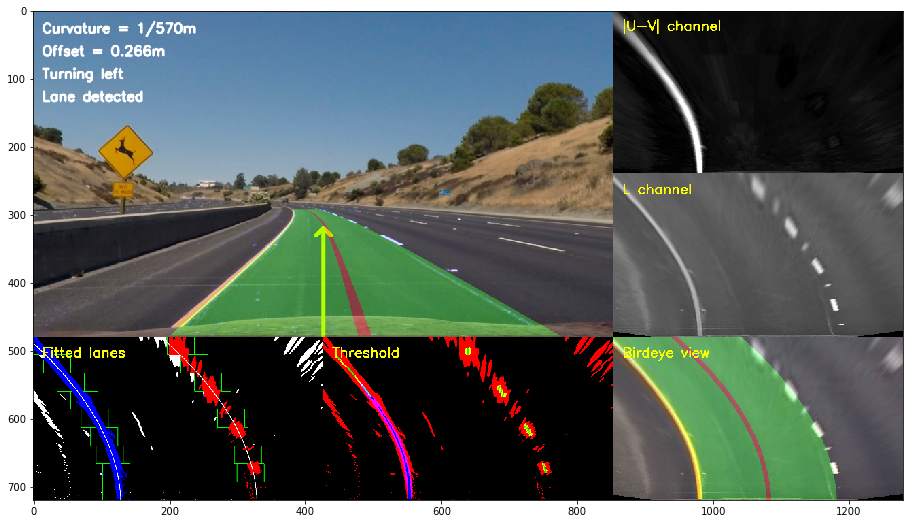

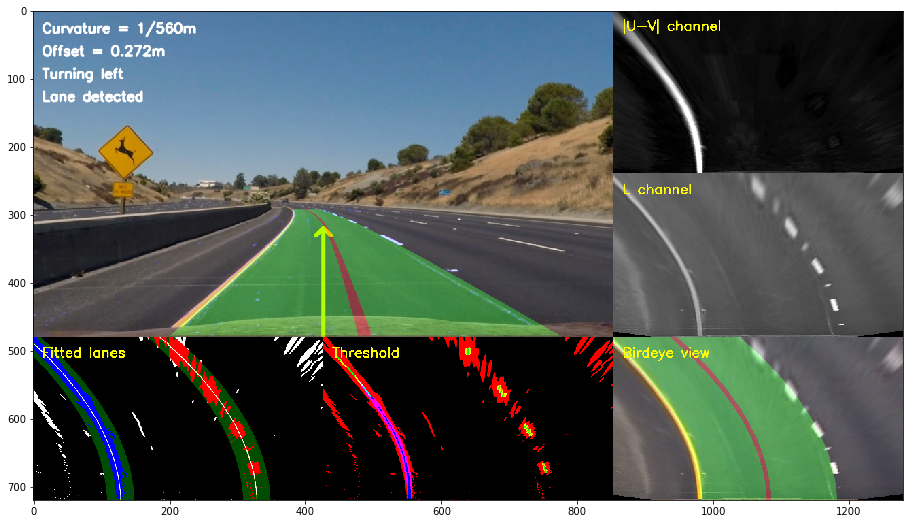

In [25]:
line = Line()
plt.figure(figsize=(16,9))
# img = clip1.get_frame(t=1)
img = cv2.imread(TEST_IMG_FOLDER + 'test2.jpg')
out1 = line.update(img)
plt.imshow(RGB(out1))
plt.figure(figsize=(16,9))
# img = clip1.get_frame(t=1.1)
img = cv2.imread(TEST_IMG_FOLDER + 'test2.jpg')
out2 = line.update(img)
plt.imshow(RGB(out2))
plt.savefig(OUT_IMG_FOLDER + 'output.jpg')

In [26]:
# clip1 = VideoFileClip("./harder_challenge_video.mp4")
# subclip = clip1.subclip(2,7)
# subclip.write_videofile('./harder_challenge_video_02to07s.mp4')

In [27]:
# clip1 = VideoFileClip("./challenge_video.mp4")
# clip1.save_frame('challenge_test_images/test4.jpg', t=3.1)
# clip1.save_frame('challenge_test_images/test5.jpg', t=3.2)
# clip1.save_frame('challenge_test_images/test6.jpg', t=3.3)

In [28]:
# clip1 = VideoFileClip("./harder_challenge_video.mp4")
# clip1.save_frame('harder_challenge_test_images/test4.jpg', t=10.1)
# clip1.save_frame('harder_challenge_test_images/test5.jpg', t=10.2)
# clip1.save_frame('harder_challenge_test_images/test6.jpg', t=10.3)
# clip1.save_frame('harder_challenge_test_images/test7.jpg', t=36.3)
# clip1.save_frame('harder_challenge_test_images/test8.jpg', t=37.3)
# clip1.save_frame('harder_challenge_test_images/test9.jpg', t=38.3)

In [29]:
# clip1 = VideoFileClip("./harder_challenge_video.mp4")
# clip1.save_frame('./test_images/straight_lines3.jpg', t= 13.08)
# plt.imshow(RGB(cv2.imread('./test_images/straight_lines3.jpg')))